<a href="https://colab.research.google.com/github/konks/meta/blob/main/Conv3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [16]:
class MyNet(nn.Module):
  def __init__(self):
    super(MyNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
    self.meta = nn.Conv3d(1, 2, (3, 3, 3), padding=1)
    self.pool2 = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
    self.fc1 = nn.Linear(4096, 40)
    self.fc2 = nn.Linear(40, 10)


  def forward(self, x):
    x = F.mish(self.conv1(x))
    x = F.mish(self.conv2(x))
    x = self.pool1(F.mish(self.conv3(x)))
    x = x.unsqueeze(1)
    x = self.pool2(F.mish(self.meta(x)))
    x = torch.flatten(x, 1) #поменять все размерности, кроме батча
    x = F.mish(self.fc1(x))
    x = self.fc2(x)
    return x

In [17]:
from tqdm import tqdm_notebook
import torch.optim as optim

net = MyNet().to(device)

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

In [18]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2           [-1, 32, 32, 32]           4,640
            Conv2d-3           [-1, 32, 32, 32]           9,248
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv3d-5        [-1, 2, 32, 16, 16]              56
         MaxPool3d-6          [-1, 2, 32, 8, 8]               0
            Linear-7                   [-1, 40]         163,880
            Linear-8                   [-1, 10]             410
Total params: 178,682
Trainable params: 178,682
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.84
Params size (MB): 0.68
Estimated Total Size (MB): 1.54
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[1,    50] loss: 2.013
[1,   100] loss: 1.750
[1,   150] loss: 1.603
[1,   200] loss: 1.540
[1,   250] loss: 1.472
[1,   300] loss: 1.402
[1,   350] loss: 1.348


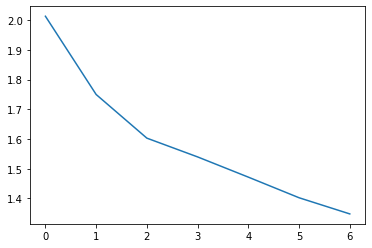

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[2,    50] loss: 1.243
[2,   100] loss: 1.217
[2,   150] loss: 1.181
[2,   200] loss: 1.188
[2,   250] loss: 1.163
[2,   300] loss: 1.146
[2,   350] loss: 1.105


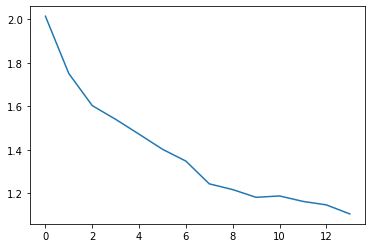

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[3,    50] loss: 0.984
[3,   100] loss: 0.994
[3,   150] loss: 0.947
[3,   200] loss: 0.982
[3,   250] loss: 0.980
[3,   300] loss: 0.948
[3,   350] loss: 0.959


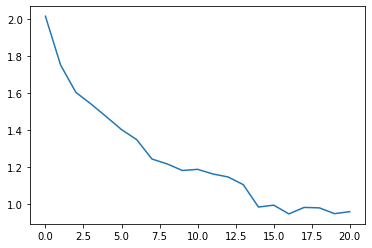

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[4,    50] loss: 0.777
[4,   100] loss: 0.783
[4,   150] loss: 0.837
[4,   200] loss: 0.824
[4,   250] loss: 0.809
[4,   300] loss: 0.814
[4,   350] loss: 0.802


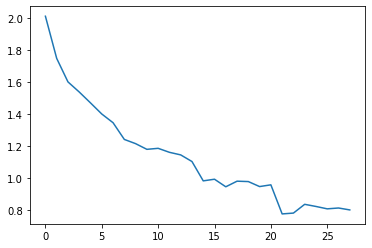

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[5,    50] loss: 0.649
[5,   100] loss: 0.683
[5,   150] loss: 0.672
[5,   200] loss: 0.675
[5,   250] loss: 0.675
[5,   300] loss: 0.684
[5,   350] loss: 0.717


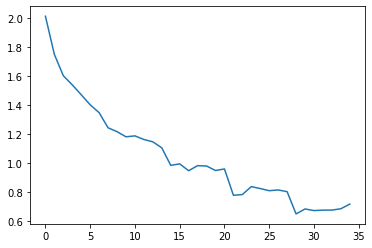

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[6,    50] loss: 0.534
[6,   100] loss: 0.549
[6,   150] loss: 0.565
[6,   200] loss: 0.569
[6,   250] loss: 0.579
[6,   300] loss: 0.604
[6,   350] loss: 0.616


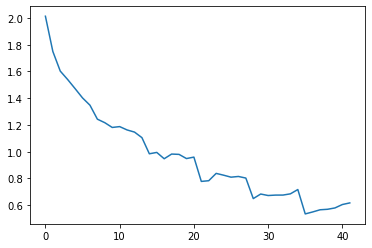

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[7,    50] loss: 0.425
[7,   100] loss: 0.445
[7,   150] loss: 0.484
[7,   200] loss: 0.476
[7,   250] loss: 0.502
[7,   300] loss: 0.507
[7,   350] loss: 0.517


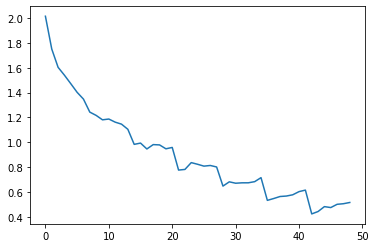

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[8,    50] loss: 0.362
[8,   100] loss: 0.367
[8,   150] loss: 0.386
[8,   200] loss: 0.397
[8,   250] loss: 0.419
[8,   300] loss: 0.438
[8,   350] loss: 0.417


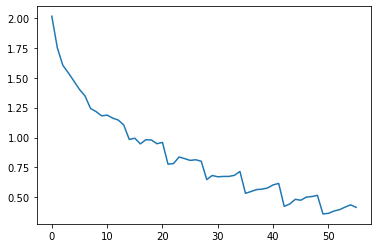

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[9,    50] loss: 0.299
[9,   100] loss: 0.291
[9,   150] loss: 0.307
[9,   200] loss: 0.332
[9,   250] loss: 0.337
[9,   300] loss: 0.353
[9,   350] loss: 0.364


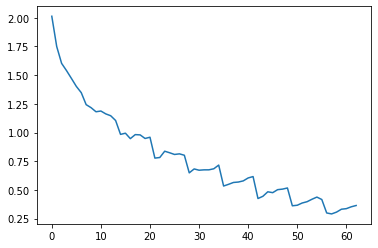

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[10,    50] loss: 0.239
[10,   100] loss: 0.234
[10,   150] loss: 0.248
[10,   200] loss: 0.258
[10,   250] loss: 0.287
[10,   300] loss: 0.304
[10,   350] loss: 0.286


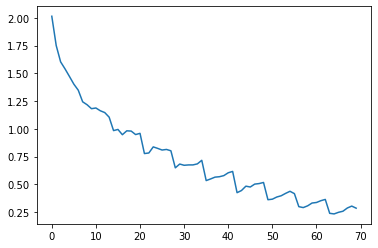

Обучение завершено


In [19]:
for epoch in tqdm_notebook(range(10)):

  running_loss = 0.0
  for i, batch in enumerate(tqdm_notebook(trainloader)): #занумеровали batch (кортеж из 4 изображений и 4 ответов)
    
    X_batch, y_batch = batch

    optimizer.zero_grad()

    y_pred = net(X_batch.to(device))
    loss = loss_fn(y_pred, y_batch.to(device)) #одномерный тензор, в котором лежит значение функции потерь
    loss.backward() #считает производные по каждому обучаемому параметру
    optimizer.step() #изменились веса

    running_loss += loss.item()

    if i % 50 == 49:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss /50))
      losses.append(running_loss / 50) #массив из значений функции потерь
      running_loss = 0.0

  plt.plot(np.arange(len(losses)), losses)
  plt.show()

print('Обучение завершено') 

In [20]:
acc = 0.0

with torch.no_grad(): #это сократит использование памяти и ускорит вычисления
  for data in testloader:
    images, labels = data
    y_pred = net(images.to(device)) #двумерный тензор с вектором изображений и "вероятностей"
    y_pred = torch.argmax(y_pred, axis=1) #превратили вектор вероятности в лейбл
    answer = torch.sum(y_pred.cpu() == labels)
    acc += answer.item() / len(testloader.dataset)

print(acc * 100, '%', sep='')

65.86999999999999%
